# Exploratory Citation Network Analysis using NetworkX

### Importing all libraries and setting directory of XML files

In [209]:
import os
import itertools
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
path = 'C:/Users/Pragati Shah/subset/'
path1='C:/Users/Pragati Shah/Downloads/sample_10000/sample_10000/'

## Creating a DataFrame which has 3 attributes:
1. Plos Article DOI 
2. Plos Article PMID
3. Reference PMID

This dataframe will be used later to find the pairwise edges in tuple form.

In [214]:
ref_all=[]
pmid_all=[]
doi_all=[]
for fn in os.listdir(path1):
    tree = ET.parse(path1+fn)  
    root = tree.getroot()    
    
    ref_list=[]
    pmid=0
    doi=0
    
    for elem in tree.iter(tag='article-id'):
        a=str(elem.attrib)
        if (a.find('pmid')>-1):        
            pmid=elem.text
        if (a.find('doi')>-1):        
            doi=elem.text
    for a in root.iter('ref'):
        for elem in a.iter('pub-id'):
            ref_list.append(elem.text)
            
    doi_list=np.repeat(doi,len(ref_list))
    pmid_list=np.repeat(pmid,len(ref_list))
    
    pmid_all.extend(pmid_list)
    doi_all.extend(doi_list)
    ref_all.extend(ref_list)
    
    
ref_source = pd.DataFrame(list(zip(doi_all,pmid_all,ref_all)),
              columns=['Doi','Pmid','Ref_Pmid']) 
    

In [215]:
ref_source.head()

,Doi,Pmid,Ref_Pmid
0,10.1371/journal.pone.0000100,17183633,2118947
1,10.1371/journal.pone.0000100,17183633,4959494
2,10.1371/journal.pone.0000100,17183633,4977839
3,10.1371/journal.pone.0000100,17183633,10884334
4,10.1371/journal.pone.0000100,17183633,11588197


## Creating a reference dataframe of both PLoS articles and citations containing:
1. PMID
2. Journal Name
3. Article Name 

This can be used for enrichment purposes in the future through a simple join.

In [223]:
node_pmid=[]
node_journal=[]
node_title=[]


for fn in os.listdir(path1):
    tree = ET.parse(path1+fn)  
    root = tree.getroot()  
    
    for elem in tree.iter(tag='article-id'):
        a=str(elem.attrib)
        if (a.find('pmid')>-1):        
            node_pmid.append(elem.text)

    
    for a in root.iter('article-meta'):
        for elem in a.iter('article-title'):
            node_title.append(elem.text)

    for elem in tree.iter(tag='journal-title'):
        node_journal.append(elem.text)
    
    for a in root.iter('ref'):
        for elem in a.iter('source'):
            node_journal.append(elem.text)
        for elem in a.iter('pub-id'):
            node_pmid.append(elem.text)
        for elem in a.iter('article-title'):
            node_title.append(elem.text)
    
    
nodeDF = pd.DataFrame(list(zip(node_pmid,node_journal, node_title)),
              columns=['PMID','Journal','Title']) 
        

In [224]:
nodeDF.head()

,PMID,Journal,Title
0,17183633,PLoS ONE,Factors Affecting Frequency Discrimination of ...
1,2118947,Journal of Neuroscience,Frequency discrimination in the sense of flutt...
2,4959494,Science,Neural basis of the sense of flutter-vibration.
3,4977839,Journal of Neurophysiology,Cortical neuronal mechanisms in flutter-vibrat...
4,10884334,Nature Neuroscience,Neuronal correlates of decision-making in seco...


## Creating list for nodes and list of pairwise tuples for edges.

In [195]:
nodes=list(set(pmid_all+ref_all))

In [196]:
subset = ref_source[['Pmid', 'Ref_Pmid']]
tuples = [tuple(x) for x in subset.values]

In [197]:
tuples[2]

('17183633', '4977839')

## Generating a network graph using library NetworkX

In [198]:
import networkx as nx
G = nx.Graph()
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(tuples)

## Demonstration of how easily degrees of seperation between two nodes can be calculated once the network graph is built

In [199]:
deg_sep=nx.shortest_path_length(G, '17183633','11588197')

In [200]:
print(deg_sep)

1


## Calculating other properties like centrality. 
Centrality is used to identify the most important nodes in a graph. As we can calculate the centrality of all nodes using NetworkX easily, this can be used as a parameter in the final product, perhaps for ranking recommendations. 

In [217]:
dict_centrality=nx.degree_centrality(G)

In [222]:
import pandas as pd
df=pd.DataFrame.from_dict(dict_centrality,orient='index')
df.columns=['Centrality']
df['PMID'] = df.index
df=df.reset_index(drop=True)
df.head()

,Centrality,PMID
0,0.000004,11226308
1,0.000004,12894406
2,0.000007,2024485
3,0.000004,15027895
4,0.000004,778319


## Joining centrality dataframe with previously defined reference matrix on common PMID

In [227]:
centralityDF=df.merge(nodeDF, on='PMID',how='left')
centralityDF.head()

,Centrality,PMID,Journal,Title
0,0.000004,11226308,Functional and neural mechanisms of interval t...,Increased expression of the pro-apoptotic Bcl2...
1,0.000004,12894406,Mech Dev,The
2,0.000007,2024485,Onderstepoort J Veter Res,Thickness distribution of actin bundles in vitro.
3,0.000007,2024485,Journal of Physical Chemistry B,Innate and adaptive immune responses of the ce...
4,0.000004,15027895,Nature,Immune control of tuberculosis by IFN-γ-induci...


## Filtering out only PLOS journals and displaying top N.

In [237]:
centralityDF=centralityDF.dropna(axis=0, how='any')
plosCentralityDF=centralityDF[centralityDF['Journal'].str.contains('PLoS|plos|PLOS')]

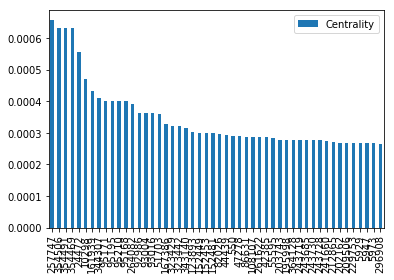

In [242]:
%matplotlib inline
plosCentralityDF.sort_values('Centrality',ascending=False).head(n=50).plot(kind='bar')

In [244]:
plosCentralityDF.sort_values('Centrality',ascending=False).head(n=20)

,Centrality,PMID,Journal,Title
257747,0.000657,19194535,PLoS ONE,Publication bias: evidence of delayed publicat...
354506,0.000632,9254694,PLoS ONE,In vitro characterization of T cells from Myco...
354491,0.000632,9254694,PLoS ONE,Genomic Scale Mutant Hunt Identifies Cell Size...
354469,0.000632,9254694,PLoS ONE,Mannose 6-phosphate receptors in an ancient ve...
24472,0.000558,17330140,PLoS ONE,A general multivariate extension of Fisher's g...
10298,0.000470,17726530,PLoS ONE,Mechanism of IFN-γ-induced endocytosis of tigh...
161939,0.000434,7984417,PLoS ONE,Transcriptional regulation of the cyclin D1 pr...
344307,0.000410,18714376,PLoS ONE,Streptococcus suis: an emerging human pathogen.
95171,0.000402,11846609,PLoS Biol,Prevalence of Panton Valentine Leukocidin gene...
95195,0.000402,11846609,PLoS ONE,Multidrug resistance pumps in bacteria: variat...
